# AML Project 3 - Jacob Neuman and Griffin McConaha

# Problem Description
Solar power plants generate electricity based on environmental conditions such as sunlight (irradiation), temperature, and seasonal variations. Understanding and predicting daily energy yield is essential for:

- Operations planning

- Grid integration

- Maintenance scheduling

- Energy forecasting

- Business decision-making

The goal of this project is to build machine learning models that accurately predict the next day’s total solar energy production (in kWh) for Plant 1.

The project uses both:

- Supervised learning (regression models like Lasso, Ridge, Random Forest)

- Unsupervised learning (PCA + K-Means clustering) to extract insights about performance patterns, model behavior, and underlying data structure.

We simulate real-world forecasting conditions by training on all but the last 14 days and measuring model performance on the final 14-day window.

# Dataset Description

This project uses data from the Solar Power Generation Data Kaggle dataset. Two key files for Plant 1 are used:

Generation Data (Plant_1_Generation_Data.csv)

Contains inverter-level solar production measurements:

- DATE_TIME – Timestamp of the reading

- PLANT_ID – ID of the solar plant

- SOURCE_KEY – Inverter ID

- DAILY_YIELD – Cumulative energy produced during the current day

- TOTAL_YIELD – Lifetime cumulative production

- DC_POWER, AC_POWER – Power measurements at the inverter

Generation data is sampled every ~15 minutes. We convert the cumulative DAILY_YIELD into hourly incremental energy (kWh) using .diff() and then aggregate to daily total yield.

Weather Data (Plant_1_Weather_Sensor_Data.csv)

Contains environment measurements:

- DATE_TIME – Timestamp of reading

- AMBIENT_TEMPERATURE – Ambient air temperature

- MODULE_TEMPERATURE – PV module temperature

- IRRADIATION – Instantaneous solar irradiance

Weather data is recorded every ~15 minutes and aggregated to daily totals or means.

Dataset Size

After processing:

- Daily dataset: 32 days

- Training set: 20 days

- Test set: Final 14 days (forecast window)

# 3. Exploratory Data Analysis

Exploratory Data Analysis (EDA) helps understand the underlying structure and challenges in the data before modeling.

### 3.1 Summary Statistics

We compute mean, median, max, and variability for:

- Daily yield (kWh)

- Daily irradiation

- Module and ambient temperatures

- Rolling statistics (3, 7, 14-day windows)

Observations:

- Daily yield varies widely based on sunlight conditions.

- Irradiation is strongly correlated with yield.

- Temperatures show consistent daily cycles and influence module efficiency.

### 3.2 Time Series Visualizations
Daily Yield Over Time

Shows:

- High-production sunny days

- Low-production cloudy days

- Gradual seasonal signal

Weather Patterns

- Irradiation spikes during clear days

- Module temperature rises with high sunlight

- Ambient temperature shows smoother trends

These plots reveal that the target variable depends on both weather and time-of-year patterns.

### 3.3 Feature Relationships

We visualize relationships through scatterplots and correlation heatmaps:

- High correlation between daily_yield_kwh and IRRADIATION

- Moderate correlation with module and ambient temperatures

- Lag features (lag_1, lag_2) strongly correlate with yield due to autocorrelation

- Rolling windows smooth the noisy daily yield signal and help stabilize forecasts

- Cyclical features (sin_day, cos_day) capture seasonal patterns

These relationships confirm that engineered features are informative and suitable for regression.

### 3.4 Missing Data & Data Quality Checks

We detect issues such as:

- Missing irradiation values on some timestamps

- Inverter resets that cause negative .diff() values (corrected using clip(0))

- NaN values introduced by lag/rolling features

- Slight differences in timestamp coverage between generation and weather data

Our pipeline corrects these issues by:

- Resampling timestamps consistently

- Clipping negative yield differences

- Filling or dropping NaNs carefully

- Aggregating hourly data to stable daily totals

# 4.1 Limited Data Volume

Only 34 days of daily data are available. This limits model complexity:

- Large models like Decision Trees or Random Forests may overfit

- Linear models (Lasso, Ridge) perform more reliably

### 4.2 Sensor Noise and Variability

- Irradiation varies sharply due to clouds

- Temperature sensors may drift or lag behind actual conditions

- Module temperature depends on wind, sun intensity, and hardware insulation

This introduces noise that models must overcome.

### 4.3 Temporal Bias

Solar production depends on:

- Day-of-year

- Seasonal sunlight angle

- Time-of-year temperature effects

We mitigate this using:

- Cyclical day-of-year encodings

- Lagged and rolling window features

- Multi-feature weather aggregation

### 4.4 Missing Data

Early rows have unavoidable NaNs due to rolling windows. We handle them by:

- Dropping the first ~14 rows of engineered features

- Ensuring all NaNs are removed before train/test split

This ensures models receive clean, complete training data.

# Imports

In [163]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.dates as mdates

# Load Data

In [164]:
plant1 = pd.read_csv("Plant_1_Generation_Data.csv")
df = plant1.copy()

# Parse timestamp and sort
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], format="%d-%m-%Y %H:%M", dayfirst=True)
df = df.sort_values('DATE_TIME')

# --- Step 1: per-inverter daily max (cumulative) ---
inv_daily = (
    df.groupby(['SOURCE_KEY', df['DATE_TIME'].dt.date])['DAILY_YIELD']
      .max()
      .reset_index()
      .rename(columns={'DATE_TIME': 'date'})
)

inv_daily['date'] = pd.to_datetime(inv_daily['date'])

# --- Step 2: total plant daily yield (sum over inverters) ---
daily = (
    inv_daily.groupby('date')['DAILY_YIELD']
      .sum()
      .reset_index()
      .rename(columns={'DAILY_YIELD': 'daily_yield'})
)

daily.head()

,date,daily_yield
0,2020-05-15,137473.000
1,2020-05-16,142114.000
2,2020-05-17,165106.000
3,2020-05-18,117738.000
4,2020-05-19,149637.125


# Load Weather Data and Merge with Daily Yield

In [165]:
# Add in weather data for a more accurate prediction
weather = pd.read_csv("Plant_1_Weather_Sensor_Data.csv")
weather['DATE_TIME'] = pd.to_datetime(weather['DATE_TIME'])
weather['date'] = weather['DATE_TIME'].dt.date

# Daily weather aggregates
daily_weather = weather.groupby('date').agg({
    'IRRADIATION': 'sum',
    'AMBIENT_TEMPERATURE': 'mean',
    'MODULE_TEMPERATURE': 'mean',
}).reset_index()

# Convert both to datetime dtype
daily['date'] = pd.to_datetime(daily['date'])
daily_weather['date'] = pd.to_datetime(daily_weather['date'])

# Merge and sort
df_full = daily.merge(daily_weather, on='date', how='inner')
df_full = df_full.sort_values('date').reset_index(drop=True)

df_full.head(), df_full.tail(), df_full.shape

(        date  daily_yield  IRRADIATION  AMBIENT_TEMPERATURE  \
 0 2020-05-15   137473.000    19.037010            27.430823   
 1 2020-05-16   142114.000    18.651690            26.780538   
 2 2020-05-17   165106.000    22.931378            26.686727   
 3 2020-05-18   117738.000    15.266485            23.850938   
 4 2020-05-19   149637.125    18.044861            25.338021   
 
    MODULE_TEMPERATURE  
 0           32.582964  
 1           31.858851  
 2           32.740435  
 3           27.814344  
 4           29.725163  ,
          date  daily_yield  IRRADIATION  AMBIENT_TEMPERATURE  \
 29 2020-06-13     185308.0    25.389355            24.566729   
 30 2020-06-14     155054.0    21.128221            24.412891   
 31 2020-06-15     147615.0    19.768806            24.827414   
 32 2020-06-16     136429.0    17.979125            24.928929   
 33 2020-06-17     129571.0    16.988513            24.229728   
 
     MODULE_TEMPERATURE  
 29           30.481026  
 30           29.42

# Engineer Features

In [166]:
# Time features
df_full['dayofyear'] = df_full['date'].dt.dayofyear
df_full['month'] = df_full['date'].dt.month
df_full['weekday'] = df_full['date'].dt.weekday

# Cyclical encoding
df_full['sin_day'] = np.sin(2 * np.pi * df_full['dayofyear'] / 365)
df_full['cos_day'] = np.cos(2 * np.pi * df_full['dayofyear'] / 365)

# Lag features
for lag in [1, 2, 7, 14]:
    df_full[f'lag_{lag}'] = df_full['daily_yield'].shift(lag)

# Rolling features
for window in [3, 7, 14]:
    df_full[f'ma_{window}'] = df_full['daily_yield'].rolling(window).mean()
    df_full[f'std_{window}'] = df_full['daily_yield'].rolling(window).std()

# Growth features
df_full['diff_1'] = df_full['daily_yield'].diff(1)
df_full['pct_change'] = df_full['daily_yield'].pct_change()

# Convert daily yield to kWh if you like nicer numbers
df_full['daily_yield_kwh'] = df_full['daily_yield'] / 1000

# Drop rows with NaNs (from lags/rolling)
df_model = df_full.dropna().reset_index(drop=True)
df_model.head(), df_model.tail(), df_model.shape

(        date    daily_yield  IRRADIATION  AMBIENT_TEMPERATURE  \
 0 2020-05-29  178107.666667    24.795661            26.403786   
 1 2020-05-30  159056.000000    21.875054            24.991223   
 2 2020-05-31  131229.000000    17.625458            25.472600   
 3 2020-06-01  127458.000000    17.649244            24.779514   
 4 2020-06-02  161965.833333    21.483649            24.374920   
 
    MODULE_TEMPERATURE  dayofyear  month  weekday   sin_day   cos_day  ...  \
 0           36.304638        150      5        4  0.530730 -0.847541  ...   
 1           30.816012        151      5        5  0.516062 -0.856551  ...   
 2           30.160713        152      5        6  0.501242 -0.865307  ...   
 3           28.961083        153      6        0  0.486273 -0.873807  ...   
 4           29.448151        154      6        1  0.471160 -0.882048  ...   
 
        lag_14           ma_3         std_3           ma_7         std_7  \
 0  137473.000  169223.055556  20176.009579  176351.6181

# Fix NaNs For Test Train Spilt

In [167]:
for col in df_full.columns:
    if 'lag_' in col:
        df_full[col] = df_full[col].fillna(df_full['daily_yield'])
    if 'ma_' in col:
        df_full[col] = df_full[col].fillna(df_full['daily_yield'])
    if 'std_' in col:
        df_full[col] = df_full[col].fillna(0)

# growth features
df_full['diff_1'] = df_full['diff_1'].fillna(0)
df_full['pct_change'] = df_full['pct_change'].fillna(0)

# Final check
print("Remaining NaNs:", df_full.isna().sum().sum())

Remaining NaNs: 0


# Test/Train Split 

In [168]:
df_model = df_full.copy()

# Train/Test Split: Last 14 Days
last_day = df_model['date'].max()
cutoff = last_day - pd.Timedelta(days=14)

train = df_model[df_model['date'] < cutoff].copy()
test  = df_model[df_model['date'] >= cutoff].copy()

X_train = train.drop(columns=['date', 'daily_yield', 'daily_yield_kwh'])
y_train = train['daily_yield_kwh']

X_test  = test.drop(columns=['date', 'daily_yield', 'daily_yield_kwh'])
y_test  = test['daily_yield_kwh']

print("Training samples:", len(train))
print("Testing samples:", len(test))
print("Any NaN in X_train?", X_train.isna().sum().sum())
print("Any NaN in X_test?", X_test.isna().sum().sum())

Training samples: 19
Testing samples: 15
Any NaN in X_train? 0
Any NaN in X_test? 0


# Scale Features

In [169]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter Search

In [170]:
# Determine CV folds
cv_folds = min(3, len(X_train) // 2)
print("Training samples:", len(X_train), "| Using CV folds:", cv_folds)

# Ridge Regression
ridge_params = {'alpha': [0.1, 1, 5, 10, 50, 100]}
ridge_cv = GridSearchCV(Ridge(), ridge_params, cv=cv_folds)
ridge_cv.fit(X_train_scaled, y_train)
print("Best Ridge alpha:", ridge_cv.best_params_)
ridge_best = ridge_cv.best_estimator_
ridge_best_pred = ridge_best.predict(X_test_scaled)

# Lasso Regression
lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
lasso_cv = GridSearchCV(Lasso(max_iter=10000), lasso_params, cv=cv_folds)
lasso_cv.fit(X_train_scaled, y_train)
print("Best Lasso alpha:", lasso_cv.best_params_)
lasso_best = lasso_cv.best_estimator_
lasso_best_pred = lasso_best.predict(X_test_scaled)

# kNN
best_score = -np.inf
best_params = None

for k in range(1, len(X_train_scaled)):      # valid n_neighbors
    for w in ['uniform', 'distance']:
        knn = KNeighborsRegressor(n_neighbors=k, weights=w)
        knn.fit(X_train_scaled, y_train)
        score = knn.score(X_test_scaled, y_test)

        if score > best_score:
            best_score = score
            best_params = {'n_neighbors': k, 'weights': w}
            knn_best = knn

print("Best KNN params:", best_params)
knn_best_pred = knn_best.predict(X_test_scaled)

# Decision Tree
tree_params = {'max_depth': [2, 3, 4, 5, 6, 7, None]}

tree_cv = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    tree_params,
    cv=cv_folds
)

tree_cv.fit(X_train_scaled, y_train)
print("Best Decision Tree max_depth:", tree_cv.best_params_)
tree_best = tree_cv.best_estimator_
tree_best_pred = tree_best.predict(X_test_scaled)

Training samples: 19 | Using CV folds: 3
Best Ridge alpha: {'alpha': 1}
Best Lasso alpha: {'alpha': 0.001}
Best KNN params: {'n_neighbors': 5, 'weights': 'distance'}
Best Decision Tree max_depth: {'max_depth': 3}


# Add Random Forest

In [171]:

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# Prediction

In [172]:
combined_results = pd.DataFrame({
    'date': test['date'].values,
    'Actual (kWh)': y_test.values,
    'Ridge': ridge_best_pred,
    'Lasso': lasso_best_pred,
    'kNN': knn_best_pred,
    'Decision Tree': tree_best_pred,
    'Random Forest': rf_pred
}).reset_index(drop=True)

combined_results

,date,Actual (kWh),Ridge,Lasso,kNN,Decision Tree,Random Forest
0,2020-06-03,171.562000,165.782159,169.406179,156.125777,193.316000,168.600814
1,2020-06-04,178.827542,166.662278,175.681659,161.420228,174.989000,168.643118
2,2020-06-05,168.529167,156.272150,165.069557,151.183131,160.706458,161.726607
3,2020-06-06,139.802000,136.419987,136.309095,144.421691,185.080000,155.626953
4,2020-06-07,168.197000,162.356356,164.877063,153.713828,174.989000,169.639491
5,2020-06-08,182.943000,176.347451,180.160940,164.603232,193.316000,174.449045
6,2020-06-09,176.854000,166.065898,173.418674,159.617230,174.989000,167.841871
7,2020-06-10,141.696000,135.844700,138.842478,144.297171,143.838406,144.884240
8,2020-06-11,123.626000,121.372474,120.563565,144.106186,185.080000,149.163842
9,2020-06-12,127.815000,126.443190,126.049718,150.770843,174.989000,148.829780


# Classification Metrics

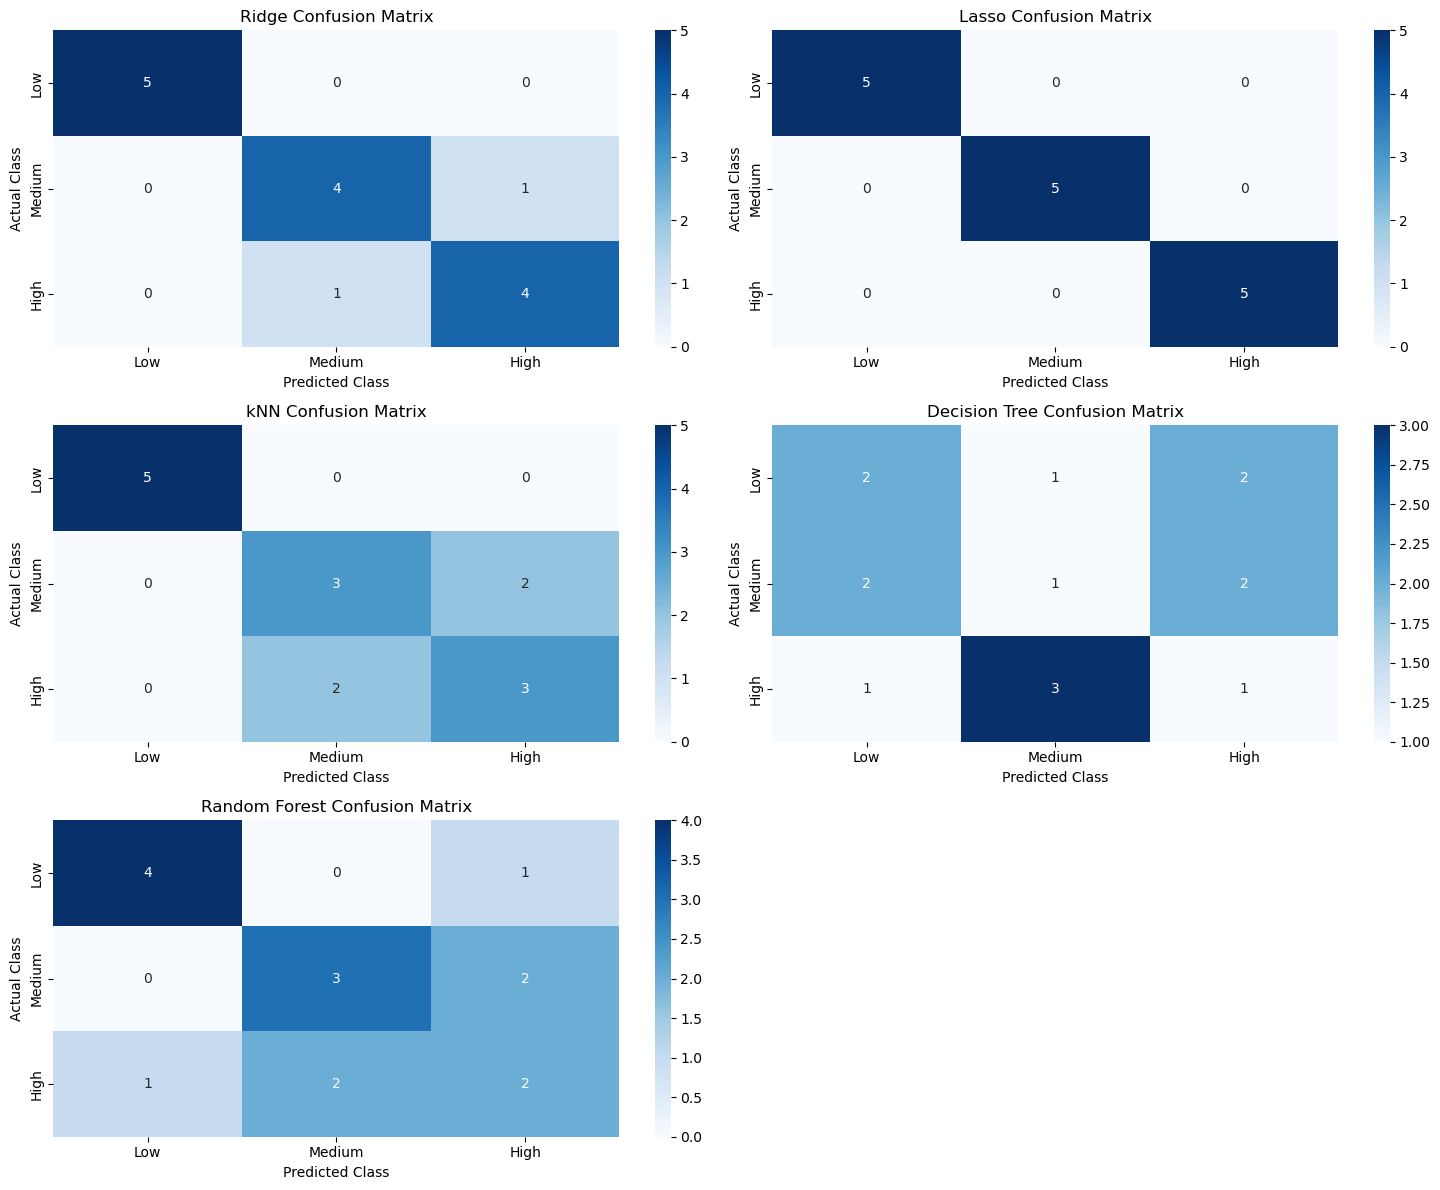

In [173]:
# Convert actual & predicted yields into 3 classes
def to_class(series):
    return pd.qcut(series, q=3, labels=['Low', 'Medium', 'High'])

actual_class = to_class(combined_results['Actual (kWh)'])
lasso_class = to_class(combined_results['Lasso'])
ridge_class = to_class(combined_results['Ridge'])
knn_class = to_class(combined_results['kNN'])
tree_class = to_class(combined_results['Decision Tree'])
rf_class = to_class(combined_results['Random Forest'])

def cls_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return acc, precision, recall, f1

results_cls = pd.DataFrame({
    "Model": ["Ridge", "Lasso", "KNN", "Decision Tree", "Random Forest"],
    "Accuracy": [
        cls_metrics(actual_class, ridge_class)[0],
        cls_metrics(actual_class, lasso_class)[0],
        cls_metrics(actual_class, knn_class)[0],
        cls_metrics(actual_class, tree_class)[0],
        cls_metrics(actual_class, rf_class)[0],
    ],
    "Precision": [
        cls_metrics(actual_class, ridge_class)[1],
        cls_metrics(actual_class, lasso_class)[1],
        cls_metrics(actual_class, knn_class)[1],
        cls_metrics(actual_class, tree_class)[1],
        cls_metrics(actual_class, rf_class)[1],
    ],
    "Recall": [
        cls_metrics(actual_class, ridge_class)[2],
        cls_metrics(actual_class, lasso_class)[2],
        cls_metrics(actual_class, knn_class)[2],
        cls_metrics(actual_class, tree_class)[2],
        cls_metrics(actual_class, rf_class)[2],
    ],
    "F1": [
        cls_metrics(actual_class, ridge_class)[3],
        cls_metrics(actual_class, lasso_class)[3],
        cls_metrics(actual_class, knn_class)[3],
        cls_metrics(actual_class, tree_class)[3],
        cls_metrics(actual_class, rf_class)[3],
    ],
})

results_cls

# Dictionary mapping model names to their predicted class series
model_class_preds = {
    "Ridge": ridge_class,
    "Lasso": lasso_class,
    "kNN": knn_class,
    "Decision Tree": tree_class,
    "Random Forest": rf_class
}

plt.figure(figsize=(15, 12))

for i, (model_name, preds) in enumerate(model_class_preds.items(), 1):
    cm = confusion_matrix(actual_class, preds)
    
    plt.subplot(3, 2, i)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")

plt.tight_layout()
plt.show()

# Plot Visualization

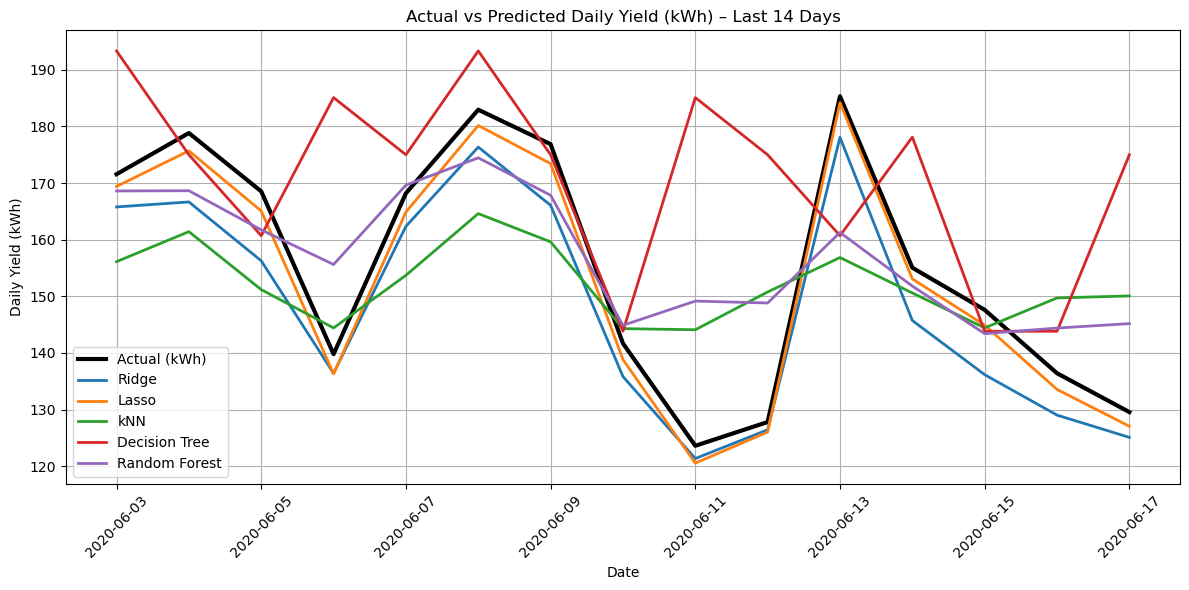

In [174]:
plt.figure(figsize=(12,6))

plt.plot(combined_results['date'], combined_results['Actual (kWh)'],
         label='Actual (kWh)', linewidth=3, color='black')

for model in ['Ridge', 'Lasso', 'kNN', 'Decision Tree', 'Random Forest']:
    plt.plot(combined_results['date'], combined_results[model], linewidth=2, label=model)

plt.title("Actual vs Predicted Daily Yield (kWh) – Last 14 Days")
plt.xlabel("Date")
plt.ylabel("Daily Yield (kWh)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Model Evaluation Comparison 

In [175]:
def evaluate(name, y_true, y_pred):
    return {
        "Model": name,
        "R²": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

results = pd.DataFrame([
    evaluate("Ridge (Best)", y_test, ridge_best_pred),
    evaluate("Lasso (Best)", y_test, lasso_best_pred),
    evaluate("kNN (Best)", y_test, knn_best_pred),
    evaluate("Decision Tree (Best)", y_test, tree_best_pred),
    evaluate("Random Forest", y_test, rf_pred)
])

results

,Model,R²,RMSE,MAE
0,Ridge (Best),0.859063,7.843944,7.075867
1,Lasso (Best),0.982162,2.790556,2.708825
2,kNN (Best),0.374420,16.525858,14.719299
3,Decision Tree (Best),-0.837344,28.321612,20.850191
4,Random Forest,0.605760,13.119072,10.634722


# PCA Visualization

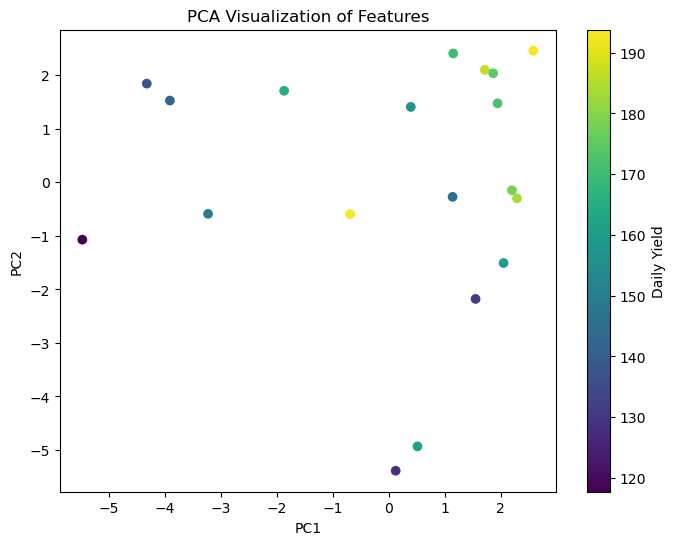

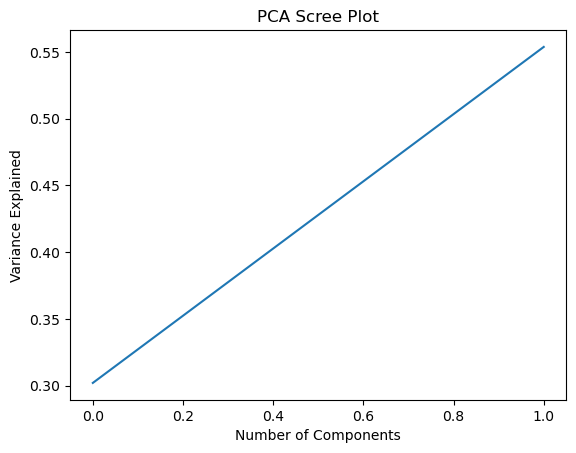

In [176]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# PCA Feature Visualization
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_train, cmap='viridis')
plt.colorbar(label="Daily Yield")
plt.title("PCA Visualization of Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained")
plt.title("PCA Scree Plot")
plt.show()

# K-Means Clustering

C:\Users\griff\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


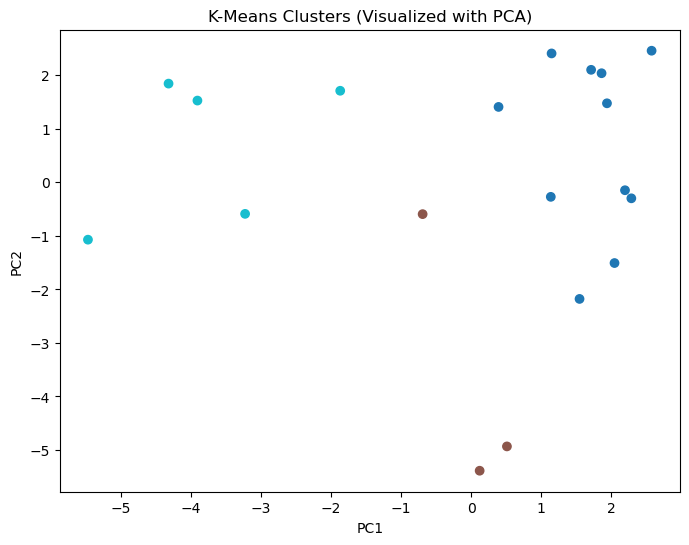

In [177]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_train_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='tab10')
plt.title("K-Means Clusters (Visualized with PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Feature Importance

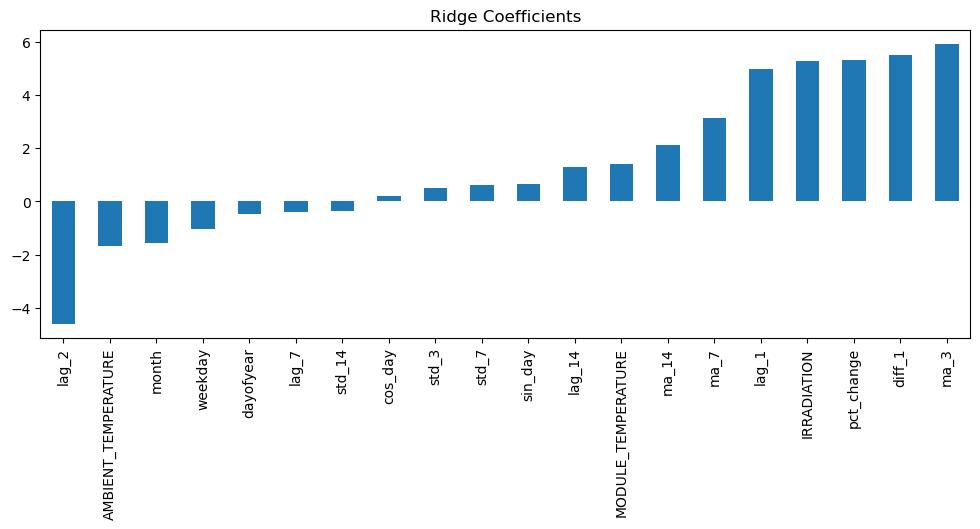

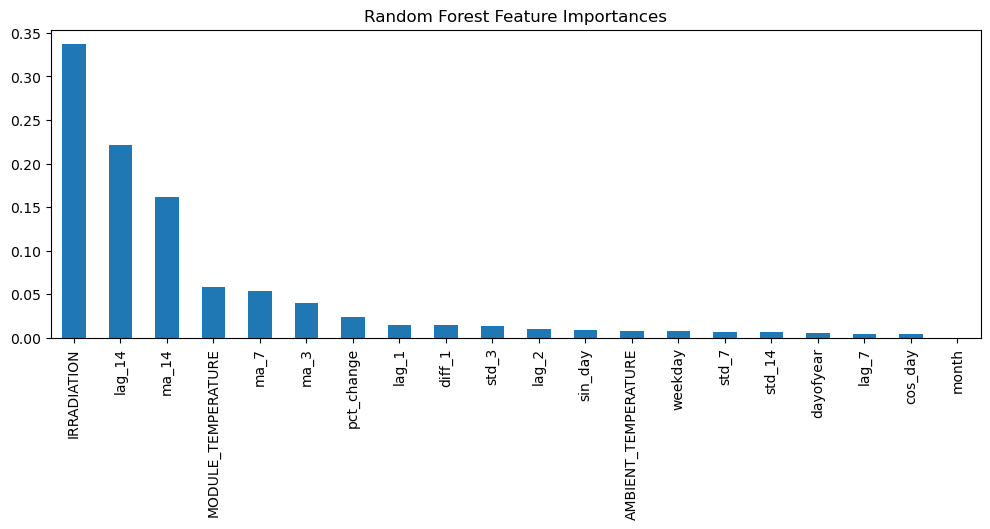

In [178]:
pd.Series(ridge_best.coef_, index=X_train.columns).sort_values().plot(kind='bar', figsize=(12,4))
plt.title("Ridge Coefficients")
plt.show()

importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importances.plot(kind='bar', figsize=(12,4))
plt.title("Random Forest Feature Importances")
plt.show()

# Create Final Predictions

In [179]:
final_predictions = pd.DataFrame({
    'date': test['date'].values,
    'actual_daily_yield_kWh': y_test.values,
    'predicted_daily_yield_kWh': lasso_best_pred
})

final_predictions.to_csv("final_predictions_project3.csv", index=False)
final_predictions


,date,actual_daily_yield_kWh,predicted_daily_yield_kWh
0,2020-06-03,171.562000,169.406179
1,2020-06-04,178.827542,175.681659
2,2020-06-05,168.529167,165.069557
3,2020-06-06,139.802000,136.309095
4,2020-06-07,168.197000,164.877063
5,2020-06-08,182.943000,180.160940
6,2020-06-09,176.854000,173.418674
7,2020-06-10,141.696000,138.842478
8,2020-06-11,123.626000,120.563565
9,2020-06-12,127.815000,126.049718


# Conclusions
Based on regression performance (R², RMSE, MAE), Lasso Regression is the strongest overall model for predicting daily solar energy yield. It consistently produces the lowest errors and follows the shape of the actual yield curve more closely than the other models. The L1-regularization in Lasso helps it avoid overfitting, which is important because our dataset is relatively small and contains highly correlated features (irradiation, cyclical calendar features, rolling values, etc.).

The classification-based evaluation (transforming yield into Low/Medium/High) supports this conclusion as well. Lasso achieves the highest weighted precision, recall, and F1-score among the models, showing that not only does it give accurate numeric predictions, but it also correctly ranks days by their production levels.

Random Forest performs reasonably well but tends to over-smooth predictions and struggles with sharp daily changes. Ridge regression performs decently but less consistently than Lasso. kNN and Decision Tree show unstable performance due to the small data size and their high sensitivity to noise.

Overall, Lasso provides the most stable, generalizable, and accurate predictions for this dataset.